In [1]:
import re
import pandas as pd
import numpy as np
from glob import glob
import networkx as nx
import matplotlib.pyplot as plt
from functools import reduce

# !conda install -c conda-forge tqdm -y
from tqdm import tqdm
# !pip install multiprocess
from multiprocess import Pool


In [2]:
code_dir = './ToDo List Free To Do Task Lists_v1.3_apkpure.com/'
# code_dir = './Instagram_v123.0.0.21.114_apkpure.com.apk'

In [3]:
smali_fns = glob(code_dir + 'smali/**/*.smali', recursive=True)

In [4]:
def extract_invokes(fn):
    with open(fn) as f:
        pattern = (
            '(invoke-.*)'  # invoke method
        )
        data = re.findall(pattern, f.read())
        if len(data) == 0: return pd.DataFrame()
        df = pd.DataFrame(np.array(data), columns=[
            'invoke'
        ])
        df['filename'] = fn
    return df

with Pool(8) as p:
    r = list(p.map(extract_invokes, smali_fns))
    
invokes = pd.concat(r, ignore_index=True)

In [5]:
len(invokes)

170329

In [6]:
def extract_calls(fn):
    with open(fn) as f:
        pattern = (
            '((invoke-\w+)(?:\/range)? '  # invoke method
            + '(?:{(?:\w\d+(?:, \w\d+)*)*}|{\w\d+ .. \w\d+}), '  # argument registers
            + '(\[?[ZBSCFIJD]|\[?L[\w\/$]+;)'  # library
            + '->([\w$]+|<init>)'  # function name
            + '\((\[*[VZBSCFIJD]|\[*L[\w\/$]+;)*\)'  # argument types
            + '(\[?[VZBSCFIJD]|\[?L[\w\/$]+;))'  # return value
        )
        data = re.findall(pattern, f.read())
        if len(data) == 0: return pd.DataFrame()
        df = pd.DataFrame(np.array(data), columns=[
            'call', 'invoke_method', 'class', 'function', 'argument_types', 'return_type',
        ])
        df['filename'] = fn
    return df

In [7]:
with Pool(8) as p:
    r = list(p.map(extract_calls, smali_fns))
    
calls = pd.concat(r, ignore_index=True)

In [8]:
len(calls)

170329

In [9]:
calls.invoke_method.value_counts()

invoke-virtual      81871
invoke-static       36878
invoke-direct       32990
invoke-interface    16589
invoke-super         2001
Name: invoke_method, dtype: int64

In [154]:
list(set(invokes.invoke) - set(calls.call))

[]

In [10]:
calls.head()

,call,invoke_method,class,function,argument_types,return_type,filename
0,"invoke-direct {p0}, Landroidx/transition/PathM...",invoke-direct,Landroidx/transition/PathMotion;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
1,"invoke-direct {v0}, Landroid/graphics/Path;-><...",invoke-direct,Landroid/graphics/Path;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
2,"invoke-direct {v0}, Landroid/graphics/Matrix;-...",invoke-direct,Landroid/graphics/Matrix;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
3,"invoke-virtual {v0, v1, v2}, Landroid/graphics...",invoke-virtual,Landroid/graphics/Path;,lineTo,F,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
4,"invoke-direct {p0}, Landroidx/transition/PathM...",invoke-direct,Landroidx/transition/PathMotion;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...


In [102]:
calls.sample(20)

,call,invoke_method,class,function,argument,return,filename
140217,"invoke-virtual {p0}, Lcom/google/android/gms/i...",invoke-virtual,Lcom/google/android/gms/internal/gtm/zzcm;,zzfv,,J,./ToDo List Free To Do Task Lists_v1.3_apkpure...
77725,"invoke-interface {p1}, Ljava/util/List;->isEmp...",invoke-interface,Ljava/util/List;,isEmpty,,Z,./ToDo List Free To Do Task Lists_v1.3_apkpure...
24610,"invoke-virtual {p0, p1}, Landroidx/recyclervie...",invoke-virtual,Landroidx/recyclerview/widget/RecyclerView$Lay...,removeView,Landroid/view/View;,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
95244,"invoke-direct {p0}, Lcom/google/android/gms/in...",invoke-direct,Lcom/google/android/gms/internal/ads/zzawi;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
93234,"invoke-virtual {v1, p2, v8}, Lcom/google/andro...",invoke-virtual,Lcom/google/android/gms/internal/ads/zzdri;,zza,Ljava/util/Map$Entry;,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
31863,"invoke-virtual {p0, p2}, Landroidx/appcompat/w...",invoke-virtual,Landroidx/appcompat/widget/ToolbarWidgetWrapper;,setTitle,Ljava/lang/CharSequence;,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
61280,"invoke-interface {v9, v0}, Landroid/database/C...",invoke-interface,Landroid/database/Cursor;,getLong,I,J,./ToDo List Free To Do Task Lists_v1.3_apkpure...
100565,"invoke-static {v0, p2}, Lcom/google/android/gm...",invoke-static,Lcom/google/android/gms/internal/ads/zzbsu;,zzb,Ljava/util/concurrent/Executor;,Lcom/google/android/gms/internal/ads/zzbsu;,./ToDo List Free To Do Task Lists_v1.3_apkpure...
20691,"invoke-virtual {p2, p1}, Ljava/io/PrintWriter;...",invoke-virtual,Ljava/io/PrintWriter;,print,Ljava/lang/String;,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
106820,"invoke-interface {p1, v2, v3, v0}, Ljava/util/...",invoke-interface,Ljava/util/concurrent/Future;,get,Ljava/util/concurrent/TimeUnit;,Ljava/lang/Object;,./ToDo List Free To Do Task Lists_v1.3_apkpure...


In [64]:
a = calls[0].values

In [79]:
set(a) - set([i for i in a if re.search(
    '(invoke-\w+) '  # invoke method
    + '{(?:\w\d+(?:, \w\d+)*)*}, '  # argument registers
    + '(\[?[ZBSCFIJD]|\[?L[\w\/$]+;)'  # library
    + '->([\w$]+|<init>)'  # function name
    + '\((?:\[*[VZBSCFIJD]|\[*L[\w\/$]+;)*\)'  # argument types
    + '(\[?[VZBSCFIJD]|\[?L[\w\/$]+;)'  # return value
    ,
    i
)])

set()

In [288]:
calls_1.iloc[0].values

array(['invoke-direct {p0}, Landroidx/transition/PathMotion;-><init>()V',
       'invoke-direct',
       './ToDo List Free To Do Task Lists_v1.3_apkpure.com/smali/androidx/transition/PatternPathMotion.smali'],
      dtype=object)

In [285]:
calls_1

,0,1,filename
0,"invoke-direct {p0}, Landroidx/transition/PathM...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
1,"invoke-direct {v0}, Landroid/graphics/Path;-><...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
2,"invoke-direct {v0}, Landroid/graphics/Matrix;-...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
3,"invoke-virtual {v0, v1, v2}, Landroid/graphics...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...
4,"invoke-direct {p0}, Landroidx/transition/PathM...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
...,...,...,...
155373,"invoke-direct {p0, p1, v0, v1, v2}, Landroid/d...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
155374,"invoke-direct {v1, p0}, Lcom/komorebi/multitod...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
155375,"invoke-virtual {p1, v0}, Landroid/database/sql...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...
155376,"invoke-virtual {p1, p2}, Landroid/database/sql...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...


In [292]:
pd.concat([calls, calls_1], ignore_index=True).drop_duplicates()

,0,1,filename
0,"invoke-direct {p0}, Landroidx/transition/PathM...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
1,"invoke-direct {v0}, Landroid/graphics/Path;-><...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
2,"invoke-direct {v0}, Landroid/graphics/Matrix;-...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
3,"invoke-virtual {v0, v1, v2}, Landroid/graphics...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...
7,"invoke-virtual {p1, p2, v0}, Landroid/content/...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...
...,...,...,...
166288,"invoke-virtual {p2, p1, v0, v1, v2}, Landroid/...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...
166292,"invoke-direct {p0, p1, v0, v1, v2}, Landroid/d...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
166293,"invoke-direct {v1, p0}, Lcom/komorebi/multitod...",invoke-direct,./ToDo List Free To Do Task Lists_v1.3_apkpure...
166294,"invoke-virtual {p1, v0}, Landroid/database/sql...",invoke-virtual,./ToDo List Free To Do Task Lists_v1.3_apkpure...


In [247]:
calls.head()

,0,1,2,3,4,filename
0,invoke-direct,Landroidx/transition/PathMotion;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
1,invoke-direct,Landroid/graphics/Path;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
2,invoke-direct,Landroid/graphics/Matrix;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
3,invoke-virtual,Landroid/graphics/Path;,lineTo,FF,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...
4,invoke-direct,Landroidx/transition/PathMotion;,<init>,,V,./ToDo List Free To Do Task Lists_v1.3_apkpure...


In [146]:
calls['class->function'].value_counts()[:15]

Ljava/lang/StringBuilder;->append                                           3349
Ljava/lang/String;->valueOf                                                 1420
Ljava/lang/String;->length                                                  1128
Lcom/google/android/gms/internal/ads/zzdxp;->get                            1042
Ljava/lang/StringBuilder;->toString                                          850
Ljava/lang/Integer;->valueOf                                                 785
Ljava/lang/String;->equals                                                   764
Ljava/util/Iterator;->next                                                   677
Ljava/util/Iterator;->hasNext                                                663
Lcom/google/android/gms/measurement/internal/zzey;->zza                      656
Ljava/util/Map;->get                                                         524
Ljava/util/Map;->put                                                         514
Lcom/google/android/gms/inte

In [239]:
def extract_methods(fn):
    with open(fn) as f:
        pattern = '\.method[\s\S]+?(?=\.end method)'
        data = re.findall(pattern, f.read())
        if len(data) == 0: return None
    return [(fn, d) for d in data]

In [240]:
with Pool(8) as p:
    r = list(p.map(extract_methods, smali_fns))
r = [i for i in r if i is not None]

methods = reduce(lambda x, y: x+y, r)

In [241]:
len(methods)

50742

In [242]:
methods[0][1]

'.method public constructor <init>()V\n    .locals 3\n\n    .line 53\n    invoke-direct {p0}, Landroidx/transition/PathMotion;-><init>()V\n\n    .line 46\n    new-instance v0, Landroid/graphics/Path;\n\n    invoke-direct {v0}, Landroid/graphics/Path;-><init>()V\n\n    iput-object v0, p0, Landroidx/transition/PatternPathMotion;->mPatternPath:Landroid/graphics/Path;\n\n    .line 48\n    new-instance v0, Landroid/graphics/Matrix;\n\n    invoke-direct {v0}, Landroid/graphics/Matrix;-><init>()V\n\n    iput-object v0, p0, Landroidx/transition/PatternPathMotion;->mTempMatrix:Landroid/graphics/Matrix;\n\n    .line 54\n    iget-object v0, p0, Landroidx/transition/PatternPathMotion;->mPatternPath:Landroid/graphics/Path;\n\n    const/high16 v1, 0x3f800000    # 1.0f\n\n    const/4 v2, 0x0\n\n    invoke-virtual {v0, v1, v2}, Landroid/graphics/Path;->lineTo(FF)V\n\n    .line 55\n    iget-object v0, p0, Landroidx/transition/PatternPathMotion;->mPatternPath:Landroid/graphics/Path;\n\n    iput-object v

In [ ]:
'\.method (\w+)( \w+)? ([\w\d$]+|<init>|<clinit>)\(((?:[VZBSCFIJD]|L[a-zA-Z$\/]+;)*)\)([VZBSCFIJD]|L[a-zA-Z$\/]+;)[\s\S]+?(?=\.end method)'

In [ ]:
'(invoke-\w+) \{\w\d(?:, \w\d)*}, (L[a-zA-Z0-9$\/$]+;)->(\w+|<init>)\(((?:[VZBSCFIJD]|L[a-zA-Z$\/]+;)*)\)([VZBSCFIJD]|L[a-zA-Z$\/]+;)'

In [126]:
def extract_class(fn):
    with open(fn) as f:
        pattern = '\.class ([a-z]+) (L[a-zA-Z0-9$\/$]+;)\n\.super (L[a-zA-Z0-9$\/$]+;)'
        data = re.findall(pattern, f.read())
        if len(data) == 0: return pd.DataFrame()
        df = pd.DataFrame(data, columns=['class_type', 'class_name', 'class_super'])
        df['filename'] = fn
    return df

In [127]:
with Pool(8) as p:
    r = list(p.map(extract_class, smali_fns))
    
classes = pd.concat(r, ignore_index=True)

In [128]:
classes.head()

,class_type,class_name,class_super,filename
0,public,Landroidx/transition/PatternPathMotion;,Landroidx/transition/PathMotion;,./ToDo List Free To Do Task Lists_v1.3_apkpure...
1,abstract,Landroidx/transition/Slide$CalculateSlideHoriz...,Ljava/lang/Object;,./ToDo List Free To Do Task Lists_v1.3_apkpure...
2,public,Landroidx/transition/AutoTransition;,Landroidx/transition/TransitionSet;,./ToDo List Free To Do Task Lists_v1.3_apkpure...
3,final,Landroidx/transition/ImageViewUtils$1;,Landroid/animation/AnimatorListenerAdapter;,./ToDo List Free To Do Task Lists_v1.3_apkpure...
4,public,Landroidx/transition/TransitionInflater;,Ljava/lang/Object;,./ToDo List Free To Do Task Lists_v1.3_apkpure...


In [129]:
classes.class_type.unique()

array(['public', 'abstract', 'final', 'synthetic'], dtype=object)

In [42]:
inheritance = nx.DiGraph()

In [43]:
for i, row in classes.iterrows():
    inheritance.add_edge(row['super_class'], row['class'])

In [63]:
inheritance.out_degree('Ljava/lang/Object;')

1538

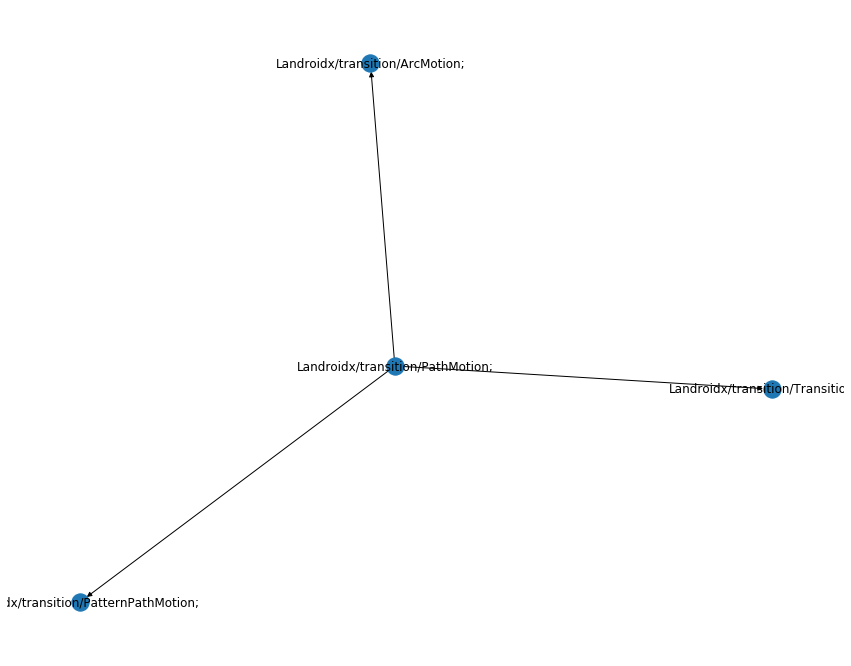

In [96]:
plt.subplots(figsize=(15, 12))
nx.draw(nx.dfs_tree(inheritance, source='Landroidx/transition/PathMotion;', depth_limit=2), with_labels=True)

In [92]:
pd.Series(nx.algorithms.centrality.degree_centrality(inheritance)).sort_values(ascending=False)

Ljava/lang/Object;                                       0.571110
Lcom/google/android/gms/internal/measurement/zzx$zza;    0.013739
Lcom/google/android/gms/tagmanager/zzbq;                 0.011883
Landroid/util/Property;                                  0.006313
Landroid/view/ViewGroup;                                 0.006313
                                                           ...   
Lcom/google/android/gms/internal/ads/zzyo;               0.000371
Lcom/google/android/gms/internal/ads/zzck;               0.000371
Lcom/google/android/gms/internal/ads/zzdfo;              0.000371
Lcom/google/android/gms/internal/ads/zzdpy;              0.000371
Lcom/google/android/gms/internal/ads/zzdig;              0.000371
Length: 2694, dtype: float64